# Dự đoán giá chứng khoán trong 1 ngày tiếp theo của Amazon
---

## 1. Import thư viện
---

In [1]:
import pandas as pd 

# phải cài cái này để load dữ liệu về
from pandas_datareader.data import DataReader

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ cho ngầu 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM
# phải cài cái này 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

## 2. Download data
---

In [2]:
df = DataReader('AMZN', data_source='yahoo', start='2009-01-01', end='2019-12-31')
df
# df = pd.read_csv('AMZN.csv')
# df = df.set_index('Date')
# df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-12-31,51.689999,49.910000,50.740002,51.279999,7792200,51.279999
2009-01-02,54.529999,51.070000,51.349998,54.360001,7296400,54.360001
2009-01-05,55.740002,53.029999,55.730000,54.060001,9509800,54.060001
2009-01-06,58.220001,53.750000,54.549999,57.360001,11080100,57.360001
2009-01-07,56.950001,55.349998,56.290001,56.200001,7942700,56.200001
...,...,...,...,...,...,...
2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300,1789.209961
2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400,1868.770020
2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600,1869.800049


In [49]:
df.shape

(2769, 6)

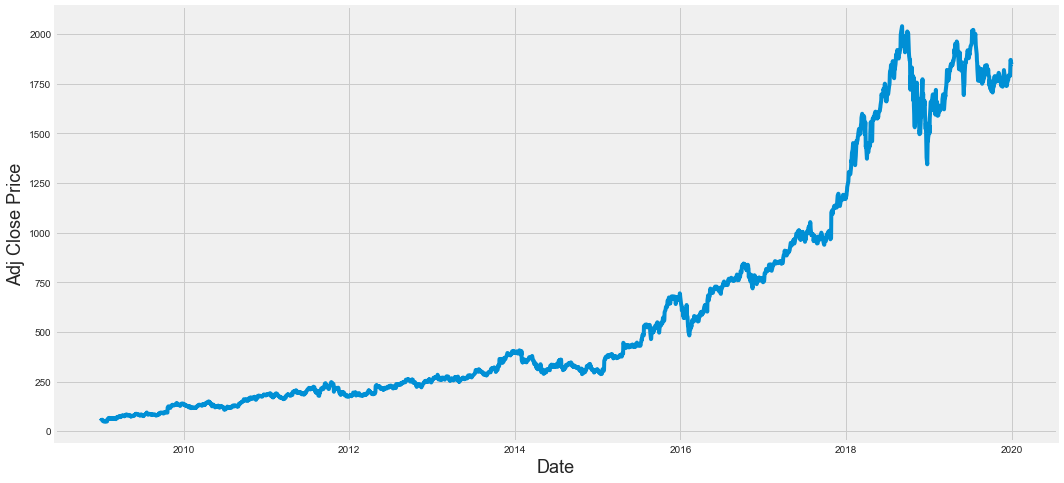

In [3]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.show()

## 3. Chia tập dữ liệu để làm việc
---

In [4]:
def splitDataset(df):
    length = df.shape[0]
    sixtyPercent = length * 60 // 100
    eightyPercent = length * 80 // 100
    train_df = df[:sixtyPercent]
    val_df = df[sixtyPercent:eightyPercent]
    test_df = df[eightyPercent:]
    return train_df, val_df, test_df

train_df, val_df, test_df = splitDataset(df)

train_df.shape, val_df.shape, test_df.shape

((1661, 6), (554, 6), (554, 6))

## 4. Tiền xử lý tập train và tạo `preprocess_pipeline`
---

In [5]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Adj Close'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(1661, 1)

In [6]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(1661,)

In [7]:
# tạo dữ liệu train_X và train_y
def createTrainX_y(scaled_train_data, time_steps=60, out_length=1):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y(scaled_train_data)
train_X.shape, train_y.shape

((1601, 60, 1), (1601, 1))

In [8]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y)),
])

train_X, train_y = preprocess_pipeline.fit_transform(train_df)
train_X.shape, train_y.shape

((1601, 60, 1), (1601, 1))

## 5. Tạo model để xử lý tập validation
---

In [30]:
# Tạo model 
def createModel(train_X, time_steps=60, out_length=1):
    model = Sequential()
    model.add(LSTM(60, activation='tanh', return_sequences=False, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

- Để có thể dự đoán được các giá trị trong tập val, ta cần 60 giá trị cuối cùng của tập train 
- Do đó, cần tạo mảng input chứa các dữ liệu nêu trên để có thể dự đoán

In [24]:
# xử lý tập validation
# tạo tập inputs
val_inputs = df[len(df) - len(val_df) - 60:]
val_X, val_y = preprocess_pipeline.transform(val_inputs)
val_X.shape, val_y.shape

((554, 60, 1), (554, 1))

In [25]:
# thử nhiều tham số epochs để tìm ra model tốt nhất
epochs_ = [1,2,3,4,5,6]
best_val_err = float('inf')
best_epoch = None

for e in epochs_:
    # build model 
    model = createModel(train_X)
    model.fit(train_X, train_y, batch_size=1, epochs=e)

    # dự đoán tập inputs
    pred_val = model.predict(val_X)
    pred_val = preprocess_pipeline.inverse_transform(pred_val)

    val_df['Predict'] = pred_val
    mse = np.sqrt(np.mean(((val_df['Predict'] - val_df['Adj Close']) ** 2)))
    if mse < best_val_err:
        best_val_err = mse 
        best_epoch = e
        print(e, mse)

2095/2095 [==============================] - 77s 35ms/step - loss: 0.0023
1 728.8201737379424
Epoch 1/2
2095/2095 [==============================] - 77s 35ms/step - loss: 0.0055
Epoch 2/2
2095/2095 [==============================] - 74s 35ms/step - loss: 4.8109e-04
Epoch 1/3
2095/2095 [==============================] - 78s 36ms/step - loss: 0.0036
Epoch 2/3
2095/2095 [==============================] - 75s 36ms/step - loss: 4.1629e-04
Epoch 3/3
2095/2095 [==============================] - 75s 36ms/step - loss: 3.4172e-04
Epoch 1/4
  50/2095 [..............................] - ETA: 1:35 - loss: 0.0925

KeyboardInterrupt: 

## 6. `fit` model với tập train + valid và predict tập test 
---

In [31]:
# tạo dữ liệu train để fit (bao gồm train_df và valid_df)
train_inputs = df[:len(df) - len(test_df) - 60]
train_X, train_y = preprocess_pipeline.fit_transform(train_inputs)

# build model 
model = createModel(train_X)
model.fit(train_X, train_y, batch_size=1, epochs=3)

Epoch 1/3
2095/2095 [==============================] - 38s 17ms/step - loss: 0.0020
Epoch 2/3
2095/2095 [==============================] - 46s 22ms/step - loss: 2.7527e-04
Epoch 3/3
2095/2095 [==============================] - 41s 19ms/step - loss: 1.9225e-04


In [32]:
# tạo dữ liệu test 
test_inputs = df[len(df) - len(test_df) - 60:]
test_X, test_y = preprocess_pipeline.transform(test_inputs)

# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = preprocess_pipeline.inverse_transform(pred_test)

In [33]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = preprocess_pipeline.inverse_transform(pred_test)
pred_test.shape

(554, 1)

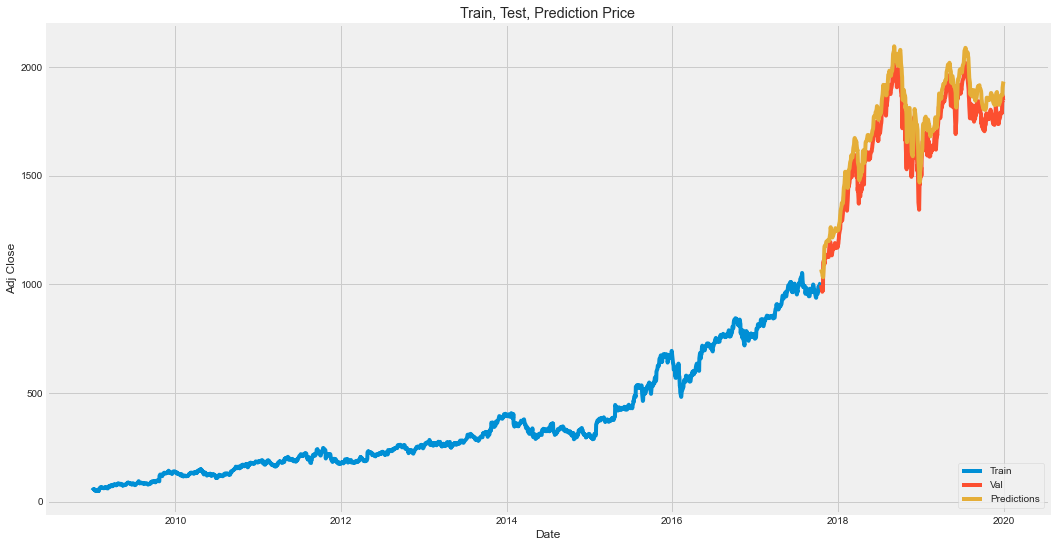

In [34]:
# vẽ đồ thị phần train, test và predict 
length = df.shape[0]
eightyPercent = length * 80 // 100
train = df[:eightyPercent]
test = df[eightyPercent:]
test['Predictions'] = pred_test

plt.figure(figsize=(16,9))
plt.title('Train, Test, Prediction Price')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
test

,High,Low,Open,Close,Volume,Adj Close,Predictions
Date,,,,,,,
2017-10-18,1022.309998,996.549988,1009.270020,997.000000,2499700,997.000000,1032.062012
2017-10-19,991.049988,980.239990,990.000000,986.609985,3108200,986.609985,1027.994873
2017-10-20,994.619995,982.000000,993.530029,982.909973,2365100,982.909973,1019.548401
2017-10-23,986.780029,962.500000,986.729980,966.299988,3494100,966.299988,1012.265564
2017-10-24,979.849976,965.000000,969.000000,975.900024,2723900,975.900024,1000.669983
...,...,...,...,...,...,...,...
2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300,1789.209961,1806.778809
2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400,1868.770020,1806.357666
2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600,1869.800049,1844.972168


In [21]:
mse = np.sqrt(np.mean((test['Adj Close'] - test['Predictions']) ** 2))
print(mse)

37.56402968128282
